In [1]:
#from gaia import *
import os
from matplotlib.pyplot import *
import numpy as np
import IPython
from IPython.display import Javascript, display
from ipywidgets import *
import tkinter as tk
from tkinter import filedialog
import warnings
from scipy import interpolate
warnings.filterwarnings('ignore')
%matplotlib inline

ion()
from IPython.display import HTML

import numpy as np 
import matplotlib.pyplot as plt 
from numpy import ma 
from matplotlib import ticker, cm 

from pylab import *
import matplotlib.colors as mcolors

# HTML('''
# <script>
# code_show=true; 
# function code_toggle() {
# if (code_show){ $('div.input').hide();} else { $('div.input').show();}
# code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the input code."></form>''')

In [3]:
#rho_solid = 920 # density at 270K from Hobbs 1974
#rho_salt = 2160 # NaCl
#concentration_salt = 0.05 # mass fraction
#rho_mix = ((1-concentration_salt)/rho_solid+concentration_salt/rho_salt)**(-1) # mixture density
#rhoc = 8000 # density of core, three-layer Model B (Schubert et al. 2009, Europa book)
#rhom = 3500 # density of silicate mantle, three-layer Model B (Schubert et al. 2009, Europa book)#

#G = 6.674e-11 # Gravitational constant

# radii & thickness
#Ro = 1560.8e3 # radius outer boundary
#Rc = 437e3 # radius of core, three-layer Model B (Schubert et al. 2009, Europa book)
#Rm = 1427e3 # radius of core, three-layer Model B (Schubert et al. 2009, Europa book)
#Ri = Ro-thickness # radius inner boundary

def calc_pressure(rho_ice, rho_water, rho_silicate, d_ice, d_ocean, Ro):
    G = 6.674e-11
    g = 0.113
    Ri = Ro - d_ice
    Rc = Ro - d_ice - d_ocean
    # pressure at ice-ocean interface assuming three-layered structure
    mass = (4/3)*np.pi*(Ro**3 - Ri**3)*rho_ice
    pref = G*mass*rho_ice/Ri
    
    print('Pressure at ice-ocean interface: ', pref*1e-5, ' bar', pref*1e-6, ' MPa')
    return pref

In [4]:
def calc_TempIceOcean(rho_ice, rho_water, rho_silicate, d_ice, d_ocean, Ro):
    pref = calc_pressure(rho_ice, rho_water, rho_silicate, d_ice, d_ocean, Ro)
    Tb = 273.15*(pref/(-395.2e6)+1)**(1/9) # temperature lower boundary
    
    print('Temperature at ice-ocean interface: ', Tb, ' K')
    return Tb

In [5]:
def calc_ConductiveTempProfile(rho_ice, rho_water, rho_silicate, d_ice, d_ocean, Rs, Ts, resolution): 
    
    Tc = calc_TempIceOcean(rho_ice, rho_water, rho_silicate, d_ice, d_ocean, Rs)
    
    Rc = Rs - d_ice
    n_shells = int(np.round((Rs - Rc) / resolution))
    depth = Rs - np.linspace(Rc, Rs, n_shells, endpoint=True)
    
    # T(r) = -rho*H*r**2/(6*k) - c1/(k*r) + c2
    # T(Rs) = Ts
    # T(Rc) = Tc
    temp = -1/(Rs - depth) * (Tc - Ts) * Rc * Rs / (Rc - Rs) + Ts + (Tc - Ts) * Rc / (Rc - Rs)
      
    return temp, depth

In [6]:
def calc_ConductiveTempProfileVark(klayer1, klayer2, Rinterface, rho_ice, rho_water, rho_silicate, d_ice, d_ocean, Rs, Ts, resolution):
    
    Tc = calc_TempIceOcean(rho_ice, rho_water, rho_silicate, d_ice, d_ocean, Rs)
    
    Rc = Rs - d_ice
    n_shells = int(np.round((Rs - Rc) / resolution))
    radius = np.linspace(Rc, Rs, n_shells, endpoint=True)
    depth = Rs - radius
    conductivity = np.zeros(len(depth))
    temp = np.zeros(len(depth))
    conductivity[radius > Rinterface] = klayer1
    conductivity[radius <= Rinterface] = klayer2
    
    dr = radius[1] - radius[0]
    
    mat = np.zeros((len(depth),len(depth)))
    mat[0][0] = 1
    mat[-1][-1] = 1
    
    rhs = np.zeros(len(depth))
    rhs[0] = Tc
    rhs[-1] = Ts
    
    for i in range(1, len(depth)-1):
        mat[i][i] = -1/(dr**2) * (conductivity[i]* radius[i]**2 + conductivity[i-1]* radius[i-1]**2)
        mat[i][i+1] = conductivity[i]* radius[i]**2 / (dr**2)
        mat[i][i-1] = conductivity[i-1]* radius[i-1]**2 / (dr**2)
        
    
    temp = np.linalg.solve(mat, rhs)
    
    return temp, depth

In [7]:
def calc_ConductiveTempProfileVarkT(klayer1, k0, Rinterface, rho_ice, rho_water, rho_silicate, d_ice, d_ocean, Rs, Ts, resolution, steps):
    
    Tc = calc_TempIceOcean(rho_ice, rho_water, rho_silicate, d_ice, d_ocean, Rs)
    
    Rc = Rs - d_ice
    n_shells = int(np.round((Rs - Rc) / resolution))
    radius = np.linspace(Rc, Rs, n_shells, endpoint=True)
    depth = Rs - radius
    conductivity = np.zeros(len(depth))
    temp = np.zeros(len(depth)) + Ts
    conductivity[radius > Rinterface] = klayer1
    conductivity[radius <= Rinterface] = k0/temp[radius <= Rinterface]
    
    dr = radius[1] - radius[0]
    
    mat = np.zeros((len(depth),len(depth)))
    mat[0][0] = 1
    mat[-1][-1] = 1
    
    rhs = np.zeros(len(depth))
    rhs[0] = Tc
    rhs[-1] = Ts
    
    for i in range(steps):
        for i in range(1, len(depth)-1):
            mat[i][i] = -1/(dr**2) * (conductivity[i]* radius[i]**2 + conductivity[i-1]* radius[i-1]**2)
            mat[i][i+1] = conductivity[i]* radius[i]**2 / (dr**2)
            mat[i][i-1] = conductivity[i-1]* radius[i-1]**2 / (dr**2)
        
        temp = np.linalg.solve(mat, rhs)
        conductivity[radius <= Rinterface] = k0/temp[radius <= Rinterface]
    
    return temp, depth

In [8]:
def write_data(filename, Ro, temp, depth, d_ice, conductivity_model):
    caseID = 'thermal_40km_conductive'
    file1 = open(filename,"w")
    
    rad = Ro - depth

    file_header = ["# Temperature data: \n",
                   "# Ice shell thickness: " + str(d_ice) + " \n",
                   "# Conductivity model: " + conductivity_model + " \n",
                   "# Column 1: Radius in m \n",
                   "# Column 2: Depth in m \n",
                   "# Column 3: Temperature in K \n"]

    file1.writelines(file_header)

    for i in range(len(depth)):
        line=str(rad[i]) + "\t" + str(depth[i]) + "\t" + str(temp[i]) + "\n"
        file1.write(str(line))
                
    file1.close()

----------------------------------------------------------
Ice thickness: 21000.0 m
Pressure at ice-ocean interface:  38.08606339440007  bar 3.8086063394400065  MPa
Temperature at ice-ocean interface:  272.8562517056601  K


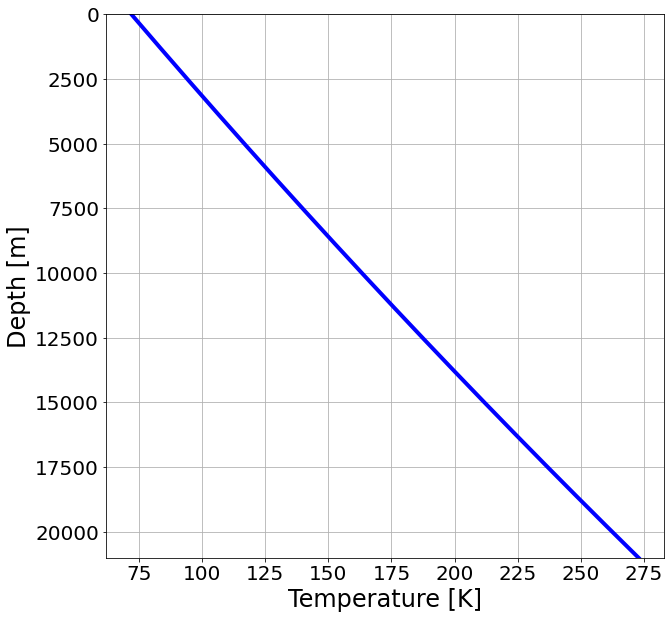

In [9]:
Ro = 252.1e3
d_ice = 21e3 # ice thickness in m
d_ocean = 37e3 # ocean thickness in m
Ts = 72 # surface temperature in K
resolution = 50 # model resolution in m
density_ice = 925 # kg/m3
density_water = 1050 # kg/m3
density_silicate = 2400 # kg/m3

print('----------------------------------------------------------')
print('Ice thickness:', d_ice, 'm')

temperature, depth = calc_ConductiveTempProfile(density_ice, density_water, density_silicate, d_ice, d_ocean, Ro, Ts, resolution)
write_data('ConductiveCase_ConstantConductivity.txt', Ro, temperature, depth, d_ice, 'constant conductivity')

fig, ax = subplots(1, 1, figsize=(10,10), sharey=True)
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 

ax.plot(temperature, depth, color='blue',linewidth=4)

ax.set_ylabel('Depth [m]', fontsize = 24) # Y label
ax.set_xlabel('Temperature [K]', fontsize = 24) # X label
ax.tick_params(axis="x", labelsize=20)
ax.tick_params(axis="y", labelsize=20)
ax.set_ylim(max(depth), 0)
ax.grid()

Pressure at ice-ocean interface:  38.08606339440007  bar 3.8086063394400065  MPa
Temperature at ice-ocean interface:  272.8562517056601  K
----------------------------------------------------------
Ice thickness: 21000.0 m Regolith thickness: 700 m
Conductivity regolith: 1 W/(mK) Conductivity ice: 2.3858716666028865 W/(mK)
Pressure at ice-ocean interface:  38.08606339440007  bar 3.8086063394400065  MPa
Temperature at ice-ocean interface:  272.8562517056601  K


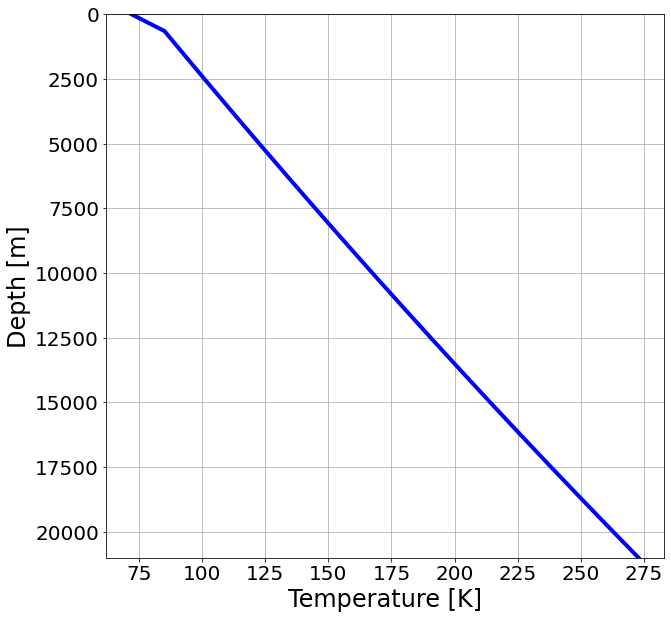

In [10]:
Ro = 252.1e3
d_regolith = 700 # regolith thickness in m
d_ocean = 37e3 # ocean thickness in m
Rinterface = Ro - d_regolith # 250m regolith
d_ice = 21e3 # ice thickness in m
Ts = 72 # surface temperature in K
resolution = 50 # model resolution in m
density_ice = 925 # kg/m3
density_water = 1050 # kg/m3
density_silicate = 2400 # kg/m3

klayer1 = 1
klayer2 = 651/calc_TempIceOcean(density_ice, density_water, density_silicate, d_ice, d_ocean, Ro)
print('----------------------------------------------------------')
print('Ice thickness:', d_ice, 'm Regolith thickness:', d_regolith, 'm')
print('Conductivity regolith:', klayer1, 'W/(mK) Conductivity ice:', klayer2, 'W/(mK)')

temperature, depth = calc_ConductiveTempProfileVark(klayer1, klayer2, Rinterface, density_ice, density_water, density_silicate, d_ice, d_ocean, Ro, Ts, resolution)
write_data('ConductiveCase_LayeredConductivity.txt', Ro, temperature, depth, d_ice, 'k_regolith = ' +  str(klayer1) + ' W/(mK), k_ice = ' + str(klayer2) + ' W/(mK), regolith thickness = ' + str(d_regolith) + ' m')

fig, ax = subplots(1, 1, figsize=(10,10), sharey=True)
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 

ax.plot(temperature, depth, color='blue',linewidth=4)

ax.set_ylabel('Depth [m]', fontsize = 24.0) # Y label
ax.set_xlabel('Temperature [K]', fontsize = 24) # X label
ax.tick_params(axis="x", labelsize=20)
ax.tick_params(axis="y", labelsize=20)
ax.set_ylim(max(depth), 0)
ax.grid()

----------------------------------------------------------
Ice thickness: 21000.0 m Regolith thickness: 250 m
Conductivity regolith: 1 W/(mK) Conductivity ice: 2.3858716666028865 W/(mK)
Pressure at ice-ocean interface:  38.08606339440007  bar 3.8086063394400065  MPa
Temperature at ice-ocean interface:  272.8562517056601  K


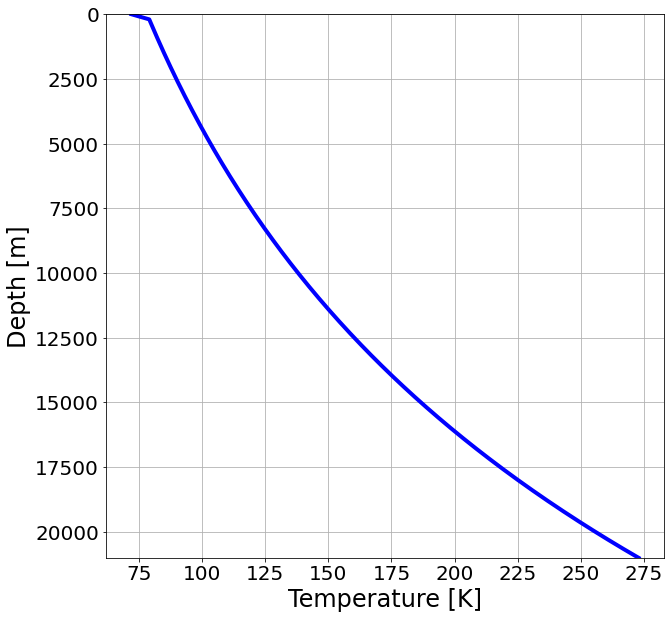

In [11]:
Ro = 252.1e3
d_regolith = 250 # regolith thickness in m
d_ocean = 37e3 # ocean thickness in m
Rinterface = Ro - d_regolith # 250m regolith
d_ice = 21e3 # ice thickness in m
Ts = 72 # surface temperature in K
resolution = 50 # model resolution in m
density_ice = 925 # kg/m3
density_water = 1050 # kg/m3
density_silicate = 2400 # kg/m3

klayer1 = 1
k0 = 651
print('----------------------------------------------------------')
print('Ice thickness:', d_ice, 'm Regolith thickness:', d_regolith, 'm')
print('Conductivity regolith:', klayer1, 'W/(mK) Conductivity ice:', klayer2, 'W/(mK)')

temperature, depth = calc_ConductiveTempProfileVarkT(klayer1, k0, Rinterface, density_ice, density_water, density_silicate, d_ice, d_ocean, Ro, Ts, resolution,10)
write_data('ConductiveCase_LayeredConductivity_VarK.txt', Ro, temperature, depth, d_ice, 'k_regolith = ' +  str(klayer1) + ' W/(mK), k_ice = ' + str(klayer2) + ' W/(mK), regolith thickness = ' + str(d_regolith) + ' m')

fig, ax = subplots(1, 1, figsize=(10,10), sharey=True)
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 

ax.plot(temperature, depth, color='blue',linewidth=4)

ax.set_ylabel('Depth [m]', fontsize = 24.0) # Y label
ax.set_xlabel('Temperature [K]', fontsize = 24) # X label
ax.tick_params(axis="x", labelsize=20)
ax.tick_params(axis="y", labelsize=20)
ax.set_ylim(max(depth), 0)
ax.grid()

Pressure at ice-ocean interface:  9.046497665400512  bar 0.9046497665400511  MPa
Temperature at ice-ocean interface:  273.0804552279639  K
Pressure at ice-ocean interface:  9.046497665400512  bar 0.9046497665400511  MPa
Temperature at ice-ocean interface:  273.0804552279639  K
Pressure at ice-ocean interface:  9.046497665400512  bar 0.9046497665400511  MPa
Temperature at ice-ocean interface:  273.0804552279639  K
Pressure at ice-ocean interface:  9.046497665400512  bar 0.9046497665400511  MPa
Temperature at ice-ocean interface:  273.0804552279639  K
Pressure at ice-ocean interface:  9.046497665400512  bar 0.9046497665400511  MPa
Temperature at ice-ocean interface:  273.0804552279639  K


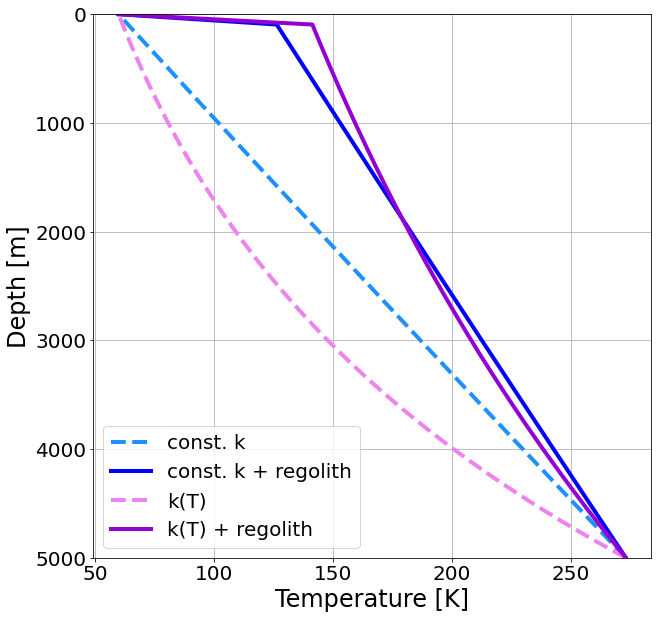

In [12]:
Ro = 252.1e3
d_regolith = 100 # regolith thickness in m
d_ocean = 37e3 # ocean thickness in m
Rinterface = Ro - d_regolith # 250m regolith
d_ice = 5e3 # ice thickness in m
Ts = 60 # surface temperature in K
resolution = 5 # model resolution in m
density_ice = 925 # kg/m3
density_water = 1050 # kg/m3
density_silicate = 2400 # kg/m3

klayer1 = 0.1
klayer2 = 651/calc_TempIceOcean(density_ice, density_water, density_silicate, d_ice, d_ocean, Ro)
k0 = 651


temperature, depth = calc_ConductiveTempProfile(density_ice, density_water, density_silicate, d_ice, d_ocean, Ro, Ts, resolution)
temperature_regolith, depth = calc_ConductiveTempProfileVark(klayer1, klayer2, Rinterface, density_ice, density_water, density_silicate, d_ice, d_ocean, Ro, Ts, resolution)
temperature_varK_regolith, depth = calc_ConductiveTempProfileVarkT(klayer1, k0, Ro, density_ice, density_water, density_silicate, d_ice, d_ocean, Ro, Ts, resolution, 10)
temperature_varK_regolith2, depth = calc_ConductiveTempProfileVarkT(klayer1, k0, Rinterface, density_ice, density_water, density_silicate, d_ice, d_ocean, Ro, Ts, resolution, 100)
    
fig, ax = subplots(1, 1, figsize=(10,10), sharey=True)
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 

ax.plot(temperature, depth,'--', color='dodgerblue', label='const. k', linewidth=4)
ax.plot(temperature_regolith, depth, color='blue', label='const. k + regolith',linewidth=4)
ax.plot(temperature_varK_regolith, depth,'--', color='violet', label='k(T)', linewidth=4)
ax.plot(temperature_varK_regolith2, depth, color='darkviolet', label='k(T) + regolith', linewidth=4)

ax.set_ylabel('Depth [m]', fontsize = 24.0) # Y label
ax.set_xlabel('Temperature [K]', fontsize = 24) # X label
ax.tick_params(axis="x", labelsize=20)
ax.tick_params(axis="y", labelsize=20)
ax.set_ylim(max(depth), 0)
ax.grid()
ax.legend(loc='lower left',fontsize = 20)

Pressure at ice-ocean interface:  38.08606339440007  bar 3.8086063394400065  MPa
Temperature at ice-ocean interface:  272.8562517056601  K
Pressure at ice-ocean interface:  38.08606339440007  bar 3.8086063394400065  MPa
Temperature at ice-ocean interface:  272.8562517056601  K
Pressure at ice-ocean interface:  38.08606339440007  bar 3.8086063394400065  MPa
Temperature at ice-ocean interface:  272.8562517056601  K
Pressure at ice-ocean interface:  38.08606339440007  bar 3.8086063394400065  MPa
Temperature at ice-ocean interface:  272.8562517056601  K
Pressure at ice-ocean interface:  38.08606339440007  bar 3.8086063394400065  MPa
Temperature at ice-ocean interface:  272.8562517056601  K


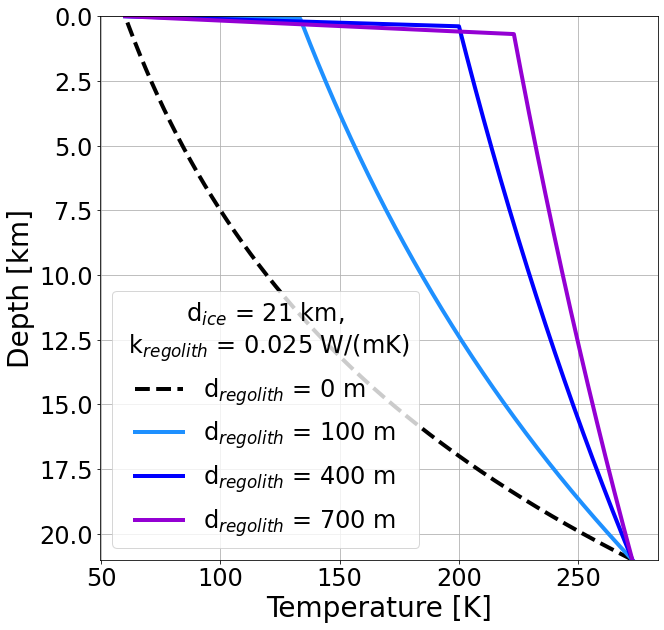

In [13]:
Ro = 252.1e3
d_regolith = 0 # regolith thickness in m
Rinterface0 = Ro - d_regolith # 250m regolith

d_regolith = 100 # regolith thickness in m
Rinterface100 = Ro - d_regolith # 250m regolith

d_regolith = 400 # regolith thickness in m
Rinterface400 = Ro - d_regolith # 250m regolith

d_regolith = 700 # regolith thickness in m
Rinterface700 = Ro - d_regolith # 250m regolith


d_ocean = 37e3 # ocean thickness in m
d_ice = 21e3 # ice thickness in m
Ts = 60 # surface temperature in K
resolution = 10 # model resolution in m
density_ice = 925 # kg/m3
density_water = 1050 # kg/m3
density_silicate = 2400 # kg/m3

klayer1 = 0.025
klayer2 = 651/calc_TempIceOcean(density_ice, density_water, density_silicate, d_ice, d_ocean, Ro)
k0 = 651


temperature_varK_regolith0, depth = calc_ConductiveTempProfileVarkT(klayer1, k0, Rinterface0, density_ice, density_water, density_silicate, d_ice, d_ocean, Ro, Ts, resolution, 10)
temperature_varK_regolith100, depth = calc_ConductiveTempProfileVarkT(klayer1, k0, Rinterface100, density_ice, density_water, density_silicate, d_ice, d_ocean, Ro, Ts, resolution, 10)
temperature_varK_regolith400, depth = calc_ConductiveTempProfileVarkT(klayer1, k0, Rinterface400, density_ice, density_water, density_silicate, d_ice, d_ocean, Ro, Ts, resolution, 100)
temperature_varK_regolith700, depth = calc_ConductiveTempProfileVarkT(klayer1, k0, Rinterface700, density_ice, density_water, density_silicate, d_ice, d_ocean, Ro, Ts, resolution, 100)


fig, ax = subplots(1, 1, figsize=(10,10), sharey=True)
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 

ax.plot(temperature_varK_regolith0, depth/1e3, '--', color='black', label='d$_{regolith}$ = 0 m', linewidth=4)
ax.plot(temperature_varK_regolith100, depth/1e3, color='dodgerblue', label='d$_{regolith}$ = 100 m', linewidth=4)
ax.plot(temperature_varK_regolith400, depth/1e3, color='blue', label='d$_{regolith}$ = 400 m',linewidth=4)
ax.plot(temperature_varK_regolith700, depth/1e3, color='darkviolet', label='d$_{regolith}$ = 700 m', linewidth=4)

ax.set_ylabel('Depth [km]', fontsize = 28.0) # Y label
ax.set_xlabel('Temperature [K]', fontsize = 28) # X label
ax.tick_params(axis="x", labelsize=24)
ax.tick_params(axis="y", labelsize=24)
ax.set_ylim(max(depth/1e3), 0)
ax.grid()
leg = ax.legend(loc='lower left',title='d$_{ice}$ = 21 km,\n k$_{regolith}$ = 0.025 W/(mK)',fontsize = 24, title_fontsize = 24)
leg.get_title().set_multialignment('center')

Pressure at ice-ocean interface:  38.08606339440007  bar 3.8086063394400065  MPa
Temperature at ice-ocean interface:  272.8562517056601  K
Pressure at ice-ocean interface:  38.08606339440007  bar 3.8086063394400065  MPa
Temperature at ice-ocean interface:  272.8562517056601  K
Pressure at ice-ocean interface:  38.08606339440007  bar 3.8086063394400065  MPa
Temperature at ice-ocean interface:  272.8562517056601  K
Pressure at ice-ocean interface:  38.08606339440007  bar 3.8086063394400065  MPa
Temperature at ice-ocean interface:  272.8562517056601  K


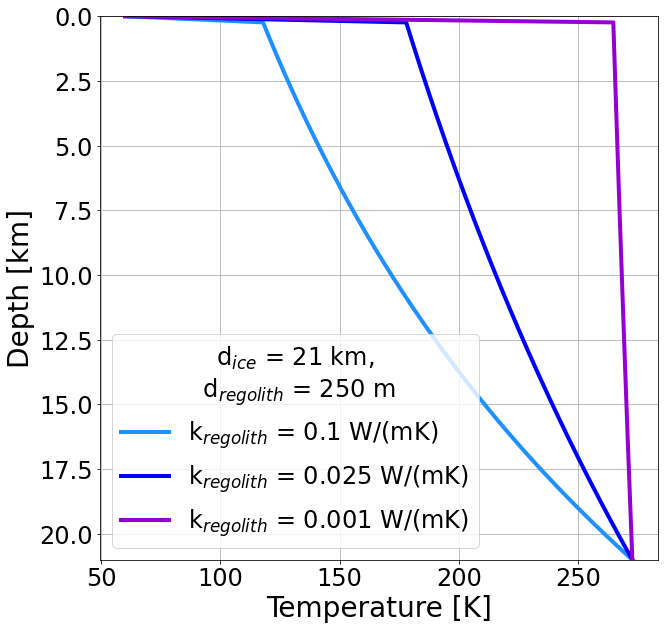

In [14]:
Ro = 252.1e3
d_regolith = 250 # regolith thickness in m
Rinterface250 = Ro - d_regolith # 250m regolith


d_ocean = 37e3 # ocean thickness in m
d_ice = 21e3 # ice thickness in m
Ts = 60 # surface temperature in K
resolution = 10 # model resolution in m
density_ice = 925 # kg/m3
density_water = 1050 # kg/m3
density_silicate = 2400 # kg/m3

klayer1 = 0.1
klayer2 = 651/calc_TempIceOcean(density_ice, density_water, density_silicate, d_ice, d_ocean, Ro)
k0 = 651


temperature_varK_regolithK01, depth = calc_ConductiveTempProfileVarkT(0.1, k0, Rinterface250, density_ice, density_water, density_silicate, d_ice, d_ocean, Ro, Ts, resolution, 10)
temperature_varK_regolithK001, depth = calc_ConductiveTempProfileVarkT(0.025, k0, Rinterface250, density_ice, density_water, density_silicate, d_ice, d_ocean, Ro, Ts, resolution, 100)
temperature_varK_regolithK0001, depth = calc_ConductiveTempProfileVarkT(0.001, k0, Rinterface250, density_ice, density_water, density_silicate, d_ice, d_ocean, Ro, Ts, resolution, 100)


fig, ax = subplots(1, 1, figsize=(10,10), sharey=True)
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 

ax.plot(temperature_varK_regolithK01, depth/1e3, color='dodgerblue', label='k$_{regolith}$ = 0.1 W/(mK)', linewidth=4)
ax.plot(temperature_varK_regolithK001, depth/1e3, color='blue', label='k$_{regolith}$ = 0.025 W/(mK)',linewidth=4)
ax.plot(temperature_varK_regolithK0001, depth/1e3, color='darkviolet', label='k$_{regolith}$ = 0.001 W/(mK)', linewidth=4)

ax.set_ylabel('Depth [km]', fontsize = 28.0) # Y label
ax.set_xlabel('Temperature [K]', fontsize = 28) # X label
ax.tick_params(axis="x", labelsize=24)
ax.tick_params(axis="y", labelsize=24)
ax.set_ylim(max(depth/1e3), 0)
ax.grid()
leg = ax.legend(loc='lower left',title='d$_{ice}$ = 21 km,\n d$_{regolith}$ = 250 m',fontsize = 24, title_fontsize = 24)
leg.get_title().set_multialignment('center')

Pressure at ice-ocean interface:  38.08606339440007  bar 3.8086063394400065  MPa
Temperature at ice-ocean interface:  272.8562517056601  K
Pressure at ice-ocean interface:  9.046497665400512  bar 0.9046497665400511  MPa
Temperature at ice-ocean interface:  273.0804552279639  K
Pressure at ice-ocean interface:  38.08606339440007  bar 3.8086063394400065  MPa
Temperature at ice-ocean interface:  272.8562517056601  K
Pressure at ice-ocean interface:  63.78940551648442  bar 6.378940551648442  MPa
Temperature at ice-ocean interface:  272.65656887563745  K


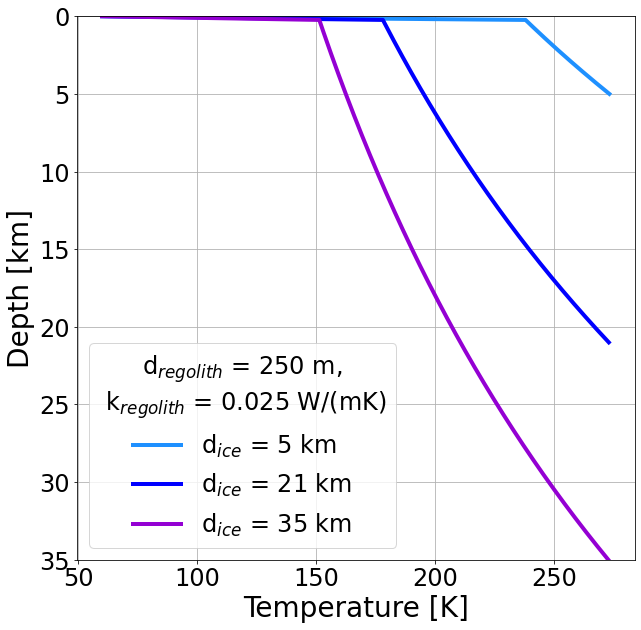

In [15]:
Ro = 252.1e3
d_regolith = 250 # regolith thickness in m
Rinterface250 = Ro - d_regolith # 250m regolith


d_ocean = 37e3 # ocean thickness in m
d_ice_5km = 5e3 # ice thickness in m
d_ice_20km = 21e3 # ice thickness in m
d_ice_35km = 35e3 # ice thickness in m
Ts = 60 # surface temperature in K
resolution = 10 # model resolution in m
density_ice = 925 # kg/m3
density_water = 1050 # kg/m3
density_silicate = 2400 # kg/m3

klayer1 = 0.025
klayer2 = 651/calc_TempIceOcean(density_ice, density_water, density_silicate, d_ice, d_ocean, Ro)
k0 = 651


temperature_varK_d5, depth_5 = calc_ConductiveTempProfileVarkT(klayer1, k0, Rinterface250, density_ice, density_water, density_silicate, d_ice_5km, d_ocean, Ro, Ts, resolution, 10)
temperature_varK_d20, depth_20 = calc_ConductiveTempProfileVarkT(klayer1, k0, Rinterface250, density_ice, density_water, density_silicate, d_ice_20km, d_ocean, Ro, Ts, resolution, 100)
temperature_varK_d35, depth_35 = calc_ConductiveTempProfileVarkT(klayer1, k0, Rinterface250, density_ice, density_water, density_silicate, d_ice_35km, d_ocean, Ro, Ts, resolution, 100)


fig, ax = subplots(1, 1, figsize=(10,10), sharey=True)
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 

ax.plot(temperature_varK_d5, depth_5/1e3, color='dodgerblue', label='d$_{ice}$ = 5 km', linewidth=4)
ax.plot(temperature_varK_d20, depth_20/1e3, color='blue', label='d$_{ice}$ = 21 km',linewidth=4)
ax.plot(temperature_varK_d35, depth_35/1e3, color='darkviolet', label='d$_{ice}$ = 35 km', linewidth=4)

ax.set_ylabel('Depth [km]', fontsize = 28.0) # Y label
ax.set_xlabel('Temperature [K]', fontsize = 28) # X label
ax.tick_params(axis="x", labelsize=24)
ax.tick_params(axis="y", labelsize=24)
ax.set_ylim(max(depth_35/1e3), 0)
ax.grid()
ax.legend(loc='lower left',fontsize = 28)
leg = ax.legend(loc='lower left',title='d$_{regolith}$ = 250 m,\n k$_{regolith}$ = 0.025 W/(mK)',fontsize = 24, title_fontsize = 24)
leg.get_title().set_multialignment('center')

Pressure at ice-ocean interface:  38.08606339440007  bar 3.8086063394400065  MPa
Temperature at ice-ocean interface:  272.8562517056601  K
Pressure at ice-ocean interface:  9.046497665400512  bar 0.9046497665400511  MPa
Temperature at ice-ocean interface:  273.0804552279639  K
Pressure at ice-ocean interface:  63.78940551648442  bar 6.378940551648442  MPa
Temperature at ice-ocean interface:  272.65656887563745  K


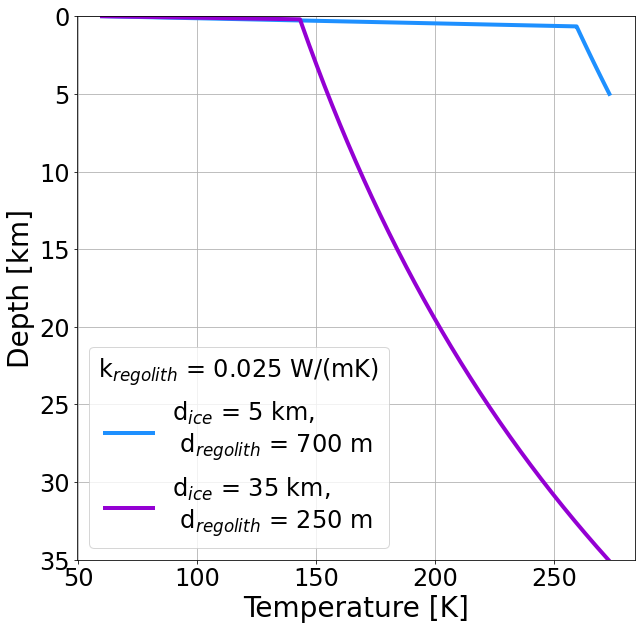

In [18]:
Ro = 252.1e3
d_regolith = 250 # regolith thickness in m
Rinterface250 = Ro - d_regolith # 250m regolith

d_regolith = 700 # regolith thickness in m
Rinterface700 = Ro - d_regolith # 250m regolith


d_ocean = 37e3 # ocean thickness in m
d_ice_5km = 5e3 # ice thickness in m
d_ice_20km = 20e3 # ice thickness in m
d_ice_35km = 35e3 # ice thickness in m
Ts = 60 # surface temperature in K
resolution = 50 # model resolution in m
density_ice = 925 # kg/m3
density_water = 1050 # kg/m3
density_silicate = 2400 # kg/m3

klayer1 = 0.025
klayer2 = 651/calc_TempIceOcean(density_ice, density_water, density_silicate, d_ice, d_ocean, Ro)
k0 = 651


temperature_varK_d5, depth_5 = calc_ConductiveTempProfileVarkT(klayer1, k0, Rinterface700, density_ice, density_water, density_silicate, d_ice_5km, d_ocean, Ro, Ts, resolution, 10)
temperature_varK_d35, depth_35 = calc_ConductiveTempProfileVarkT(klayer1, k0, Rinterface250, density_ice, density_water, density_silicate, d_ice_35km, d_ocean, Ro, Ts, resolution, 100)


fig, ax = subplots(1, 1, figsize=(10,10), sharey=True)
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 

ax.plot(temperature_varK_d5, depth_5/1e3, color='dodgerblue', label='d$_{ice}$ = 5 km, \n d$_{regolith}$ = 700 m', linewidth=4)
ax.plot(temperature_varK_d35, depth_35/1e3, color='darkviolet', label='d$_{ice}$ = 35 km, \n d$_{regolith}$ = 250 m', linewidth=4)

ax.set_ylabel('Depth [km]', fontsize = 28.0) # Y label
ax.set_xlabel('Temperature [K]', fontsize = 28) # X label
ax.tick_params(axis="x", labelsize=24)
ax.tick_params(axis="y", labelsize=24)
ax.set_ylim(max(depth_35/1e3), 0)
ax.grid()
leg = ax.legend(loc='lower left',title='k$_{regolith}$ = 0.025 W/(mK)',fontsize = 24, title_fontsize = 24)
leg.get_title().set_multialignment('center')